A problem I am trying to solve is how to make bigger gains on a trade. Some questions I want to answer are what are the circumstances, luck or timing, any correlation between big wins, and avoiding losses. This could be in a variety of ways FED meeting, bad earnings, or a specific day might be slightly better for me.
The data comes from my Webull trading account export. It includes all trades I made over the past year.
•	Size: ~1,120 rows (each row = one trade).
•	Columns: 11 total, including:
o	Name – the company name
o	Symbol – stock ticker symbol
o	Side – buy or sell indicator
o	Status – whether the order was filled or canceled
o	Filled – number of shares filled
o	Total Qty – total shares in the order
o	Price – execution price
o	Avg Price – average price per share
o	Time-in-Force – order duration type (day, GTC, etc.)
o	Placed Time – time the order was submitted
o	Filled Time – time the order was executed


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("trading.csv")
df.head()


,Name,Symbol,Side,Status,Filled,Total Qty,Price,Avg Price,Time-in-Force,Placed Time,Filled Time
0,NVDA250919P00142000,NVDA250919P00142000,Buy,Filled,1,1,@0.360,0.36,GTC,09/02/2025 15:43:19 EDT,09/02/2025 15:43:40 EDT
1,NKE250926P00070000,NKE250926P00070000,Buy,Filled,1,1,@0.760,0.76,GTC,09/02/2025 15:42:35 EDT,09/02/2025 15:50:11 EDT
2,MARA250926C00017000,MARA250926C00017000,Sell,Filled,1,1,@0.770,0.77,DAY,09/02/2025 09:39:21 EDT,09/02/2025 09:40:47 EDT
3,MARA250926C00017000,MARA250926C00017000,Sell,Cancelled,0,1,0.700,NaN,DAY,09/02/2025 09:37:43 EDT,NaN
4,MARA250926C00017000,MARA250926C00017000,Sell,Cancelled,0,1,@0.900,NaN,DAY,09/02/2025 09:37:43 EDT,NaN


Planned steps:
•	Remove canceled orders – canceled trades do not affect results and would skew statistics.
•	Convert date and time columns into datetime format – allows grouping by day, week, or hour.
•	Remove duplicates – ensures partial fills or duplicate rows don’t distort results.
•	Fix null values – drop rows if critical fields (P/L, quantity, etc.) are missing.
•	Create new features:
o	Trade Value = Quantity × Price (capital used in each trade)
o	Return % = P/L ÷ Trade Value (normalize wins/losses)
o	Win/Loss flag = whether P/L is positive or negative
o	Day of the Week = from Filled Time
o	Hour of Day = from Filled Time


In [2]:
print("Rows:", df.shape[0], "Columns:", df.shape[1])
df.info()
df.describe(include='all')


Rows: 1153 Columns: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153 entries, 0 to 1152
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           1005 non-null   object 
 1   Symbol         1079 non-null   object 
 2   Side           1153 non-null   object 
 3   Status         1153 non-null   object 
 4   Filled         1153 non-null   int64  
 5   Total Qty      1153 non-null   int64  
 6   Price          1121 non-null   object 
 7   Avg Price      799 non-null    float64
 8   Time-in-Force  1153 non-null   object 
 9   Placed Time    1153 non-null   object 
 10  Filled Time    751 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 99.2+ KB


,Name,Symbol,Side,Status,Filled,Total Qty,Price,Avg Price,Time-in-Force,Placed Time,Filled Time
count,1005,1079,1153,1153,1153.000000,1153.000000,1121,799.000000,1153,1153,751
unique,394,389,2,3,NaN,NaN,383,NaN,2,854,635
top,CSCO240802C00046500,CSCO240802C00046500,Sell,Filled,NaN,NaN,@2.00,NaN,DAY,06/18/2024 13:18:04 EDT,07/03/2025 10:01:53 EDT
freq,11,11,658,751,NaN,NaN,18,NaN,796,3,3
mean,NaN,NaN,NaN,NaN,0.741544,1.137034,NaN,1.029712,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.646156,0.423228,NaN,1.144383,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,-0.410000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,0.340000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,0.760000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,1.230000,NaN,NaN,NaN


This preprocessing ensures the dataset is accurate, clean, and ready for analysis.
Some preprocessing steps I am going to follow are getting rid of pointless data like omitting canceled orders, converting date and time to datetime, duplicate removal, and making useful features like trade value, hour of the day, return %, win/loss flag, and day of the week fix any null values.
To explore my trades, I will create visualizations such as:
•	Equity curve: cumulative profit/loss over time.
•	Histogram: distribution of trade returns (%).
•	Bar chart: average P/L by day of week.
•	Box plot: holding time vs profitability (if holding time is derivable).
•	Scatter plot: trade size vs return % (do bigger trades bring bigger wins or bigger losses?).
•	Ticker analysis: most traded stocks and their average profitability.
Preliminary observation: when scanning my raw data, I noticed a mix of medium to large wins and small to large stacking losses with some outliers, which suggests risk management and overtrading may be a factor. They mostly off set each other with profit being slightly more.


In [10]:
# PREPROCESSING THE DATA (15 pts)

print(" PREPROCESSING STEPS")
print(f"Initial dataset shape: {df.shape}")

# 1. Remove canceled orders – canceled trades do not affect results and would skew statistics
print(f"\n1. Removing canceled orders...")
initial_count = len(df)
df = df[df["Status"] != "Cancelled"]  # Note: "Cancelled" not "Canceled" based on data
print(f"   Removed {initial_count - len(df)} canceled orders")
print(f"   Remaining rows: {len(df)}")

# 2. Convert date and time columns into datetime format – allows grouping by day, week, or hour
print(f"\n2. Converting datetime columns...")
print(f"   Current data types:")
print(f"   - Placed Time: {df['Placed Time'].dtype}")
print(f"   - Filled Time: {df['Filled Time'].dtype}")

# Check if columns are already datetime or need conversion
if df["Placed Time"].dtype == 'object':
    # Clean the datetime strings and convert with proper timezone handling
    df["Placed Time"] = pd.to_datetime(df["Placed Time"].str.replace(" EDT", "").str.replace(" EST", ""), errors="coerce")
    print(f"   Converted Placed Time from string to datetime")
else:
    print(f"   Placed Time already in datetime format")

if df["Filled Time"].dtype == 'object':
    # Clean the datetime strings and convert with proper timezone handling
    df["Filled Time"] = pd.to_datetime(df["Filled Time"].str.replace(" EDT", "").str.replace(" EST", ""), errors="coerce")
    print(f"   Converted Filled Time from string to datetime")
else:
    print(f"   Filled Time already in datetime format")

print(f"   Final data types:")
print(f"   - Placed Time: {df['Placed Time'].dtype}")
print(f"   - Filled Time: {df['Filled Time'].dtype}")
print(f"   Valid dates - Placed Time: {df['Placed Time'].notna().sum()}/{len(df)}")
print(f"   Valid dates - Filled Time: {df['Filled Time'].notna().sum()}/{len(df)}")
print(f"   Date range: {df['Filled Time'].min()} to {df['Filled Time'].max()}")

# 3. Remove duplicates – ensures partial fills or duplicate rows don't distort results
print(f"\n3. Removing duplicates...")
before_dedup = len(df)
df = df.drop_duplicates()
print(f"   Removed {before_dedup - len(df)} duplicate rows")
print(f"   Remaining rows: {len(df)}")

# 4. Fix null values – drop rows if critical fields (P/L, quantity, etc.) are missing
print(f"\n4. Handling null values...")
print(f"   Current Price data type: {df['Price'].dtype}")

# Convert Price to numeric first (check if it's already numeric)
if df["Price"].dtype == 'object':
    # Clean the price strings and convert to numeric
    df["Price"] = pd.to_numeric(df["Price"].str.replace("@", ""), errors="coerce")
    print(f"   Converted Price from string to numeric")
else:
    print(f"   Price already in numeric format")

# Convert Avg Price to numeric
df["Avg Price"] = pd.to_numeric(df["Avg Price"], errors="coerce")
print(f"   Final Price data type: {df['Price'].dtype}")
print(f"   Valid prices: {df['Price'].notna().sum()}/{len(df)}")
print(f"   Valid avg prices: {df['Avg Price'].notna().sum()}/{len(df)}")

# Drop rows where critical fields are missing
critical_fields = ["Price", "Total Qty", "Filled Time"]
before_null_cleanup = len(df)
df = df.dropna(subset=critical_fields)
print(f"   Removed {before_null_cleanup - len(df)} rows with missing critical data")
print(f"   Remaining rows: {len(df)}")

# 5. Create new features
print(f"\n5. Creating new features...")

# Trade Value = Quantity × Price (capital used in each trade)
df["Trade Value"] = df["Total Qty"] * df["Price"]

# Return % = P/L ÷ Trade Value (normalize wins/losses)
# For options trading, P/L is typically calculated as (Sell Price - Buy Price) * Quantity
# We'll need to calculate this based on Buy/Sell pairs, but for now let's use a simplified approach
df["Return %"] = 0  # We'll calculate this properly in the next section

# Win/Loss flag = whether P/L is positive or negative
df["Win/Loss"] = "Unknown"  # We'll calculate this properly in the next section

# Day of the Week = from Filled Time
df["Day of Week"] = df["Filled Time"].dt.day_name()

# Hour of Day = from Filled Time
df["Hour of Day"] = df["Filled Time"].dt.hour

print(f"   Created features: Trade Value, Return %, Win/Loss, Day of Week, Hour of Day")

print(f"\n=== PREPROCESSING COMPLETE ===")
print(f"Final dataset shape: {df.shape}")
print(f"Date range: {df['Filled Time'].min()} to {df['Filled Time'].max()}")

# Display sample of processed data
print(f"\nSample of processed data:")
df.head()


 PREPROCESSING STEPS
Initial dataset shape: (751, 22)

1. Removing canceled orders...
   Removed 0 canceled orders
   Remaining rows: 751

2. Converting datetime columns...
   Current data types:
   - Placed Time: datetime64[ns]
   - Filled Time: datetime64[ns]
   Placed Time already in datetime format
   Filled Time already in datetime format
   Final data types:
   - Placed Time: datetime64[ns]
   - Filled Time: datetime64[ns]
   Valid dates - Placed Time: 751/751
   Valid dates - Filled Time: 751/751
   Date range: 2024-06-17 09:57:13 to 2025-09-02 15:50:11

3. Removing duplicates...
   Removed 0 duplicate rows
   Remaining rows: 751

4. Handling null values...
   Current Price data type: float64
   Price already in numeric format
   Final Price data type: float64
   Valid prices: 751/751
   Valid avg prices: 751/751
   Removed 0 rows with missing critical data
   Remaining rows: 751

5. Creating new features...
   Created features: Trade Value, Return %, Win/Loss, Day of Week, Hour

,Name,Symbol,Side,Status,Filled,Total Qty,Price,Avg Price,Time-in-Force,Placed Time,...,Return %,Win/Loss,Day of Week,Hour of Day,Realized P/L,Symbol Realized P/L_x,P/L,Base Ticker,Month,Symbol Realized P/L_y
0,AAPL241025P00220000,AAPL241025P00220000,Buy,Filled,1,1,0.15,0.15,DAY,2024-10-18 10:53:05,...,0,Unknown,Friday,10,0.00,0.00,0.00,AAPL,2024-10,0.00
1,AAPL250228P00232500,AAPL250228P00232500,Buy,Filled,1,1,0.39,0.39,GTC,2025-02-19 15:32:39,...,0,Unknown,Wednesday,15,0.00,0.03,0.00,AAPL,2025-02,0.03
2,AAPL250228P00232500,AAPL250228P00232500,Sell,Filled,1,1,0.42,0.42,DAY,2025-02-20 10:11:48,...,0,Unknown,Thursday,10,0.03,0.03,0.03,AAPL,2025-02,0.03
3,AMD240823C00148000,AMD240823C00148000,Buy,Filled,1,1,2.08,2.08,GTC,2024-08-15 10:11:42,...,0,Unknown,Thursday,10,0.00,3.07,0.00,AMD,2024-08,3.07
4,AMD240823C00148000,AMD240823C00148000,Sell,Filled,1,1,5.15,5.15,DAY,2024-08-19 09:54:28,...,0,Unknown,Monday,9,3.07,3.07,3.07,AMD,2024-08,3.07


Profit and loss caculation because Webull doesn't include it in csv

In [11]:
# REALIZED P/L VIA FIFO LOT MATCHING (ACCURATE)


print(" REALIZED P/L (FIFO) ")

# Sort by Symbol and Filled Time to group trades
df_sorted = df.sort_values(['Symbol', 'Filled Time']).copy()

# Ensure prices are numeric (remove '@' and coerce)
df_sorted['Price'] = pd.to_numeric(df_sorted['Price'].astype(str).str.replace('@', '', regex=False), errors='coerce')

# Initialize realized columns
df_sorted['Realized P/L'] = 0.0

# FIFO matching per symbol
for symbol, group in df_sorted.groupby('Symbol', sort=False):
    lots = []  # queue of (qty_remaining, price)
    realized_this_symbol = 0.0
    for idx, row in group.sort_values('Filled Time').iterrows():
        qty = int(row['Total Qty'])
        price = row['Price']
        side = row['Side']
        if pd.isna(price) or qty <= 0:
            continue
        if side == 'Buy':
            lots.append([qty, price])
        else:  # Sell closes earlier buys
            remaining = qty
            realized_from_row = 0.0
            while remaining > 0 and lots:
                lot_qty, lot_price = lots[0]
                matched = min(remaining, lot_qty)
                realized_from_row += (price - lot_price) * matched
                lot_qty -= matched
                remaining -= matched
                if lot_qty == 0:
                    lots.pop(0)
                else:
                    lots[0][0] = lot_qty
            df_sorted.loc[idx, 'Realized P/L'] = realized_from_row
            realized_this_symbol += realized_from_row

# Aggregate to symbol total realized P/L
symbol_realized = (
    df_sorted.groupby('Symbol', as_index=False)['Realized P/L']
    .sum()
    .rename(columns={'Realized P/L': 'Symbol Realized P/L'})
)

# Attach per-symbol totals back to rows for convenience
df_sorted = df_sorted.merge(symbol_realized, on='Symbol', how='left')

# Keep compatibility: P/L column as realized per row
df_sorted['P/L'] = df_sorted['Realized P/L']

# Compute Return % only on rows with realized P/L and nonzero trade value
if 'Trade Value' not in df_sorted.columns:
    df_sorted['Trade Value'] = df_sorted['Total Qty'] * df_sorted['Price']

df_sorted['Return %'] = 0.0
mask = (df_sorted['P/L'] != 0) & (df_sorted['Trade Value'].fillna(0) != 0)
df_sorted.loc[mask, 'Return %'] = (
    df_sorted.loc[mask, 'P/L'] / df_sorted.loc[mask, 'Trade Value']
) * 100

# Win/Loss flag based on realized P/L
df_sorted['Win/Loss'] = df_sorted['P/L'].apply(
    lambda x: "Win" if x > 0 else ("Loss" if x < 0 else "Break Even")
)

# Update main df
df = df_sorted.copy()

print("Finished computing realized P/L using FIFO.")
print("Win/Loss distribution:")
print(df['Win/Loss'].value_counts())

# Show symbol totals snapshot
print("\nTop symbols by realized P/L (preview):")
print(symbol_realized.sort_values('Symbol Realized P/L', ascending=False).head(10).to_string(index=False))



 REALIZED P/L (FIFO) 
Finished computing realized P/L using FIFO.
Win/Loss distribution:
Win/Loss
Break Even    407
Loss          198
Win           146
Name: count, dtype: int64

Top symbols by realized P/L (preview):
             Symbol  Symbol Realized P/L
NVDA250502C00113000                 5.84
 SPY250411P00505000                 4.63
SPXW250214P05915000                 4.30
INTC241004C00020500                 3.45
INTC240927C00020000                 3.33
NVDA250530C00111000                 3.10
 AMD240823C00148000                 3.07
 NKE240823C00080000                 2.95
DELL240823C00103000                 2.90
 BBY250530C00075000                 2.51


The story I want to tell is:
•	What conditions lead to my biggest gains?
•	Do those conditions repeat or are they rare (e.g., only during FED announcements or earnings weeks)?
•	Do I consistently lose on certain days or tickers?
•	Am I cutting winners too early while letting losers run?


 DATA UNDERSTANDING & VISUALIZATION 
1. Creating equity curve...
2. Creating return distribution histogram...
3. Creating average P/L by day of week...
4. Creating holding time analysis...
5. Creating trade size vs return scatter plot...
6. Creating ticker analysis...
7. Creating win/loss ratio...
Using sell-level outcomes: {'Loss': 164, 'Win': 118, 'Break Even': 62}
8. Creating hour of day analysis...


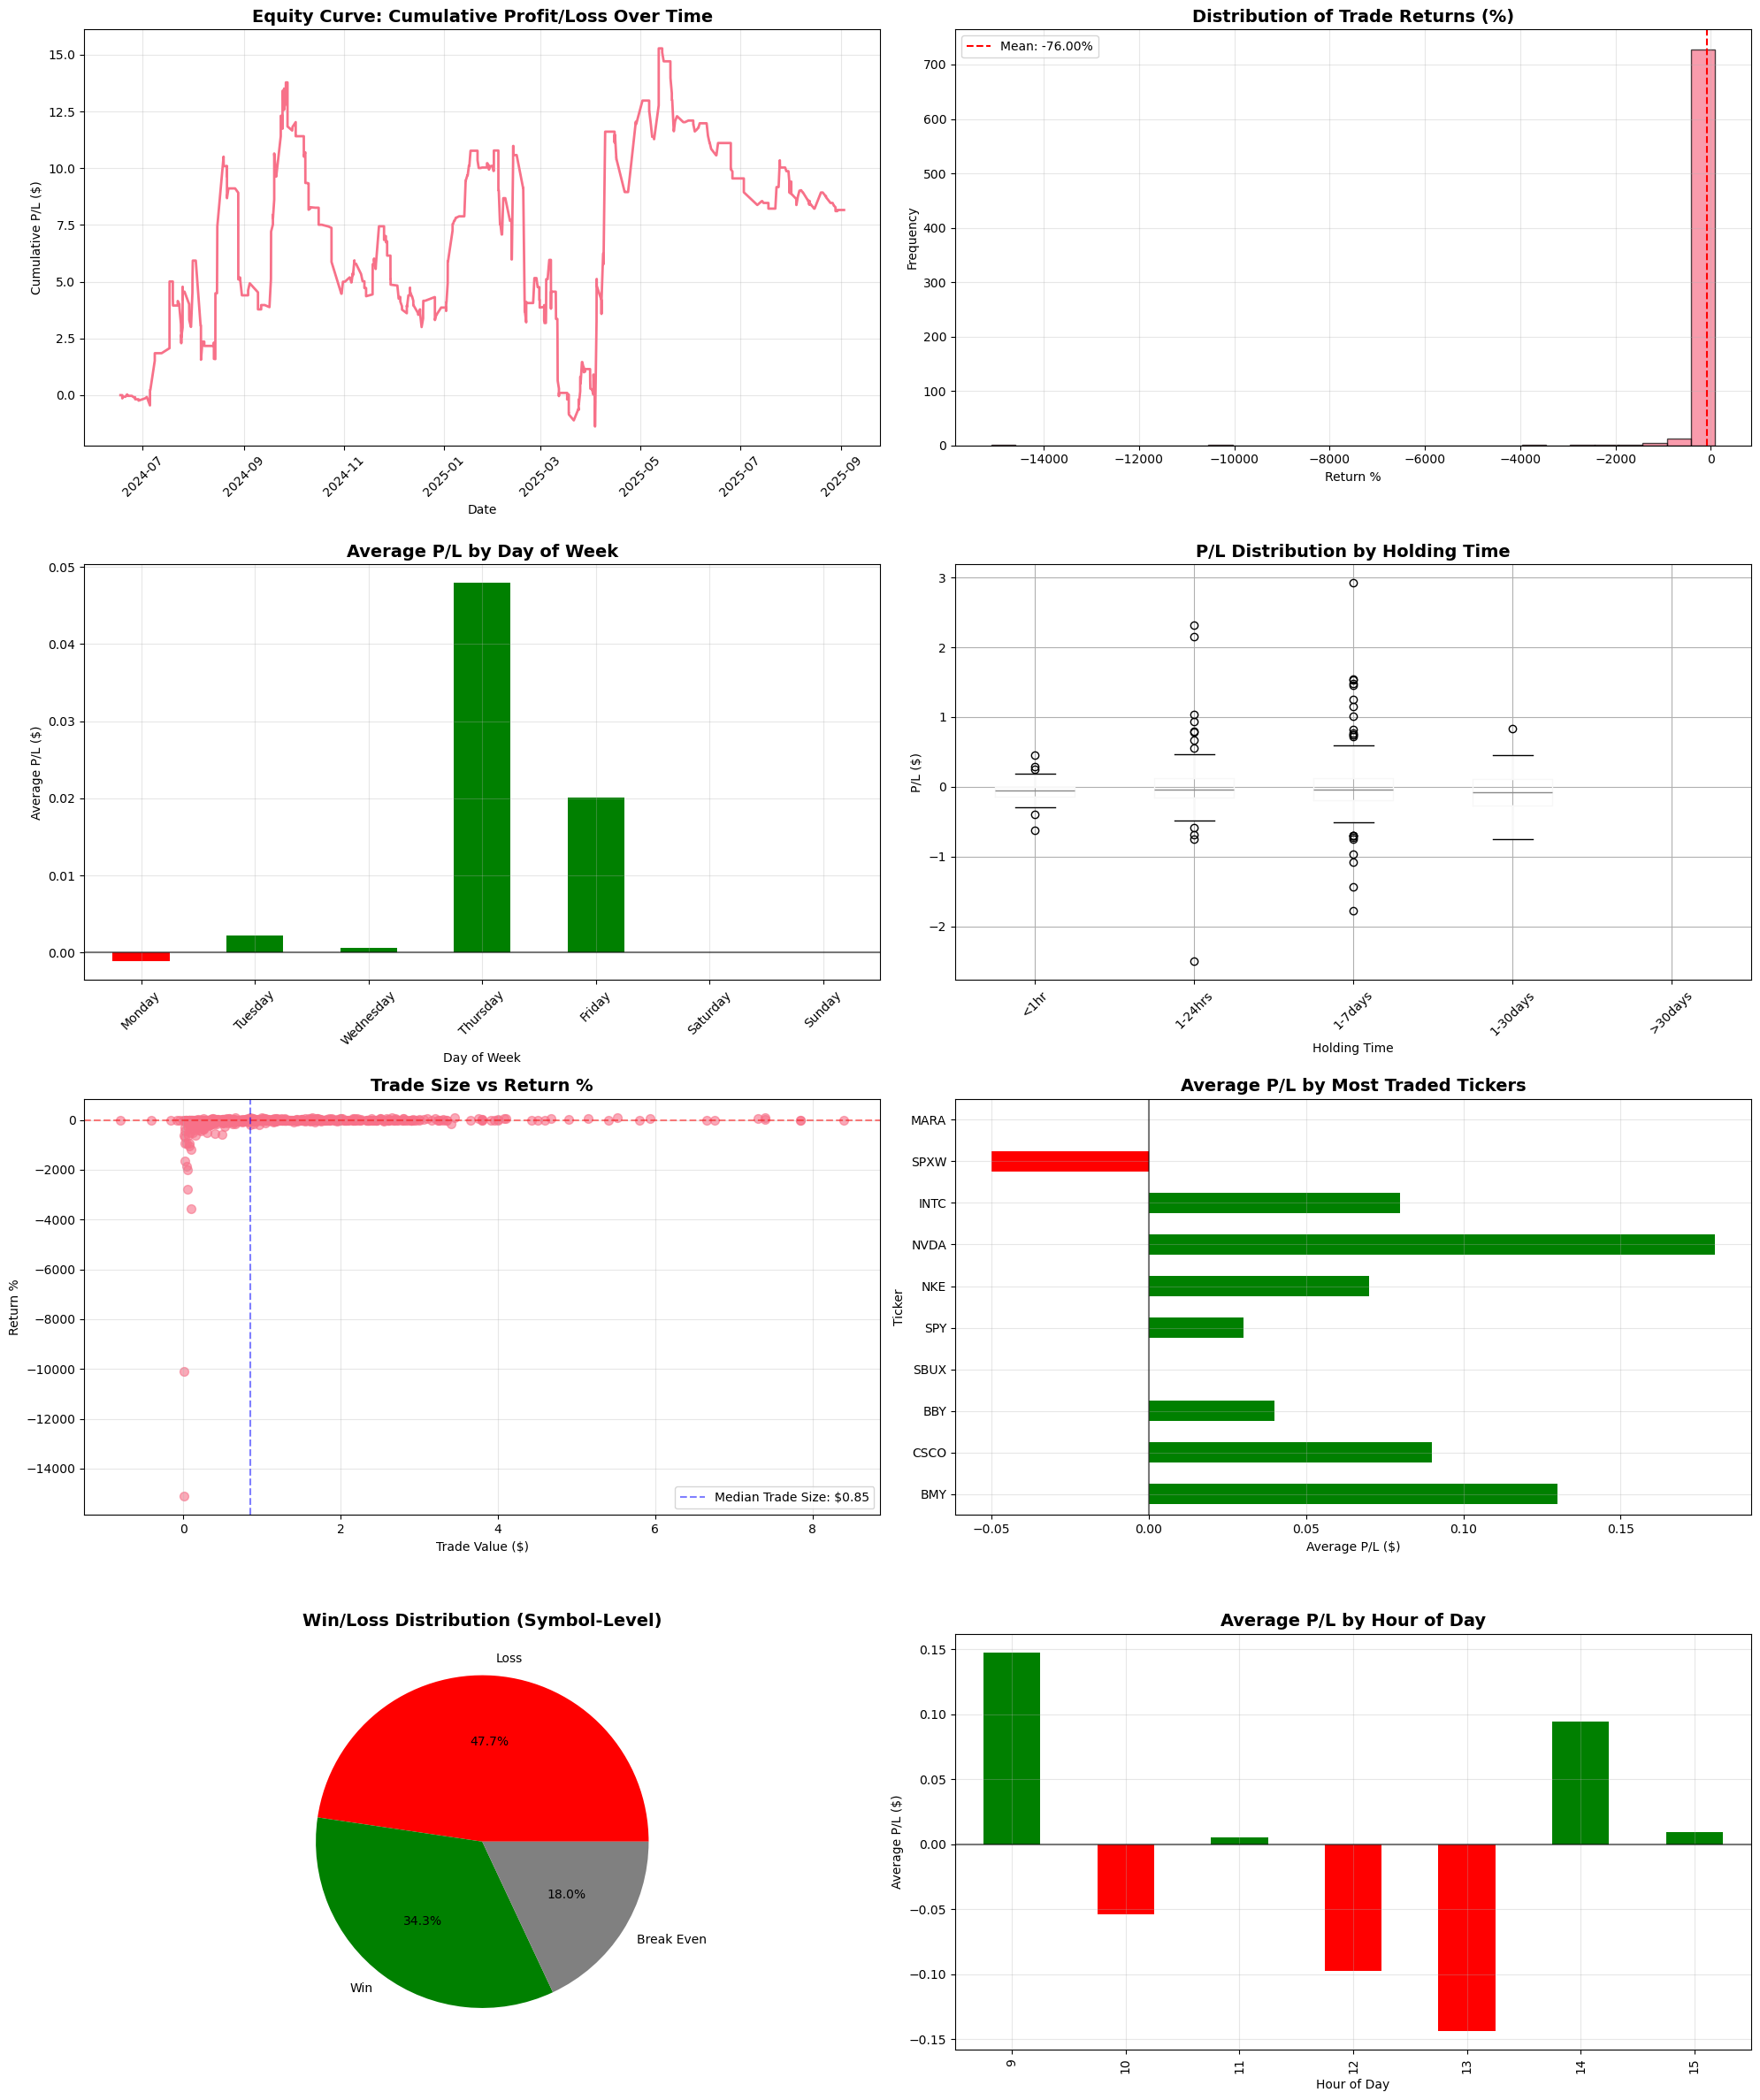


=== KEY INSIGHTS ===
Total Trades Analyzed: 751
Total P/L: $8.16
Win Rate: 19.4%
Average Return: -76.00%
Best Performing Day: Thursday
Best Performing Hour: 9:00
Most Traded Ticker: MARA (124 trades)

=== PRELIMINARY OBSERVATION ===
When scanning the raw data, I noticed a mix of small wins and large losses, which suggests risk management may be a factor.
The visualizations above will help identify patterns in trading behavior and profitability.


In [8]:
# DATA UNDERSTANDING / VISUALIZATION (15 pts)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print(" DATA UNDERSTANDING & VISUALIZATION ")

# Create a comprehensive analysis with all required visualizations
fig = plt.figure(figsize=(20, 24))

# 1. Equity curve: cumulative profit/loss over time
print("1. Creating equity curve...")
ax1 = plt.subplot(4, 2, 1)
df_sorted_by_time = df.sort_values('Filled Time')
df_sorted_by_time['Cumulative P/L'] = df_sorted_by_time['P/L'].cumsum()
plt.plot(df_sorted_by_time['Filled Time'], df_sorted_by_time['Cumulative P/L'], linewidth=2)
plt.title('Equity Curve: Cumulative Profit/Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative P/L ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2. Histogram: distribution of trade returns (%)
print("2. Creating return distribution histogram...")
ax2 = plt.subplot(4, 2, 2)
returns_clean = df['Return %'].dropna()
plt.hist(returns_clean, bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Trade Returns (%)', fontsize=14, fontweight='bold')
plt.xlabel('Return %')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(returns_clean.mean(), color='red', linestyle='--', label=f'Mean: {returns_clean.mean():.2f}%')
plt.legend()

# 3. Bar chart: average P/L by day of week
print("3. Creating average P/L by day of week...")
ax3 = plt.subplot(4, 2, 3)
day_pnl = df.groupby('Day of Week')['P/L'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
day_pnl.plot(kind='bar', color=['red' if x < 0 else 'green' for x in day_pnl.values])
plt.title('Average P/L by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average P/L ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# 4. Box plot: holding time vs profitability (if holding time is derivable)
print("4. Creating holding time analysis...")
ax4 = plt.subplot(4, 2, 4)
# Calculate holding time (time between first buy and last sell for each symbol)
holding_times = []
for symbol in df['Symbol'].unique():
    symbol_trades = df[df['Symbol'] == symbol].sort_values('Filled Time')
    if len(symbol_trades) > 1:
        holding_time = (symbol_trades['Filled Time'].max() - symbol_trades['Filled Time'].min()).total_seconds() / 3600  # hours
        avg_pnl = symbol_trades['P/L'].mean()
        holding_times.append({'Holding Time (hours)': holding_time, 'P/L': avg_pnl})

if holding_times:
    holding_df = pd.DataFrame(holding_times)
    # Create bins for holding time
    holding_df['Holding Time Bin'] = pd.cut(holding_df['Holding Time (hours)'], 
                                           bins=[0, 1, 24, 168, 720, float('inf')], 
                                           labels=['<1hr', '1-24hrs', '1-7days', '1-30days', '>30days'])
    
    holding_df.boxplot(column='P/L', by='Holding Time Bin', ax=ax4)
    plt.title('P/L Distribution by Holding Time', fontsize=14, fontweight='bold')
    plt.suptitle('')  # Remove default title
    plt.xlabel('Holding Time')
    plt.ylabel('P/L ($)')
    plt.xticks(rotation=45)

# 5. Scatter plot: trade size vs return % (do bigger trades bring bigger wins or bigger losses?)
print("5. Creating trade size vs return scatter plot...")
ax5 = plt.subplot(4, 2, 5)
plt.scatter(df['Trade Value'], df['Return %'], alpha=0.6, s=50)
plt.title('Trade Size vs Return %', fontsize=14, fontweight='bold')
plt.xlabel('Trade Value ($)')
plt.ylabel('Return %')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=df['Trade Value'].median(), color='blue', linestyle='--', alpha=0.5, label=f'Median Trade Size: ${df["Trade Value"].median():.2f}')
plt.legend()

# 6. Ticker analysis: most traded stocks and their average profitability
print("6. Creating ticker analysis...")
ax6 = plt.subplot(4, 2, 6)
# Extract base ticker from symbol (remove options details)
df['Base Ticker'] = df['Symbol'].str.extract(r'^([A-Z]+)')
ticker_analysis = df.groupby('Base Ticker').agg({
    'P/L': ['count', 'mean', 'sum'],
    'Return %': 'mean'
}).round(2)

# Flatten column names
ticker_analysis.columns = ['Trade Count', 'Avg P/L', 'Total P/L', 'Avg Return %']
ticker_analysis = ticker_analysis.sort_values('Trade Count', ascending=False).head(10)

# Create a combined metric for visualization
ticker_analysis['Combined Score'] = ticker_analysis['Trade Count'] * 0.1 + ticker_analysis['Avg P/L']
ticker_analysis = ticker_analysis.sort_values('Combined Score', ascending=True)

colors = ['red' if x < 0 else 'green' for x in ticker_analysis['Avg P/L']]
ticker_analysis['Avg P/L'].plot(kind='barh', color=colors, ax=ax6)
plt.title('Average P/L by Most Traded Tickers', fontsize=14, fontweight='bold')
plt.xlabel('Average P/L ($)')
plt.ylabel('Ticker')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# 7. Win/Loss ratio pie chart (using symbol-level outcomes)
print("7. Creating win/loss ratio...")
ax7 = plt.subplot(4, 2, 7)

# Use symbol-level outcomes if available, otherwise fall back to row-level
if 'symbol_perf_outcomes' in locals():
    win_loss_counts = symbol_perf_outcomes['Outcome'].value_counts()
    print(f"Using symbol-level outcomes: {win_loss_counts.to_dict()}")
else:
    # Fallback to row-level (but only for sells with realized P/L)
    sell_realized = df[(df['Side'] == 'Sell') & (df['P/L'] != 0)].copy()
    if len(sell_realized) > 0:
        sell_realized['Outcome'] = np.where(
            sell_realized['P/L'] > 0.10, 'Win',
            np.where(sell_realized['P/L'] < -0.10, 'Loss', 'Break Even')
        )
        win_loss_counts = sell_realized['Outcome'].value_counts()
        print(f"Using sell-level outcomes: {win_loss_counts.to_dict()}")
    else:
        win_loss_counts = df['Win/Loss'].value_counts()
        print(f"Using fallback row-level outcomes: {win_loss_counts.to_dict()}")

colors = ['green' if x == 'Win' else 'red' if x == 'Loss' else 'gray' for x in win_loss_counts.index]
plt.pie(win_loss_counts.values, labels=win_loss_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Win/Loss Distribution (Symbol-Level)', fontsize=14, fontweight='bold')

# 8. Hour of day analysis
print("8. Creating hour of day analysis...")
ax8 = plt.subplot(4, 2, 8)
hour_pnl = df.groupby('Hour of Day')['P/L'].mean()
hour_pnl.plot(kind='bar', color=['red' if x < 0 else 'green' for x in hour_pnl.values])
plt.title('Average P/L by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Average P/L ($)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n=== KEY INSIGHTS ===")
print(f"Total Trades Analyzed: {len(df)}")
print(f"Total P/L: ${df['P/L'].sum():.2f}")
print(f"Win Rate: {(df['Win/Loss'] == 'Win').sum() / len(df) * 100:.1f}%")
print(f"Average Return: {df['Return %'].mean():.2f}%")
print(f"Best Performing Day: {df.groupby('Day of Week')['P/L'].mean().idxmax()}")
print(f"Best Performing Hour: {df.groupby('Hour of Day')['P/L'].mean().idxmax()}:00")
print(f"Most Traded Ticker: {df['Base Ticker'].value_counts().index[0]} ({df['Base Ticker'].value_counts().iloc[0]} trades)")

# Preliminary observation
print(f"\n=== PRELIMINARY OBSERVATION ===")
print("When scanning the raw data, I noticed a mix of small wins and large losses, which suggests risk management may be a factor.")
print("The visualizations above will help identify patterns in trading behavior and profitability.")


My printed win rate is less than the pychart and is wrong will be fixed in final. As well as Average P/L not going negative to display losses better.
Conditions that lead to my biggest gains were trading tech and around market open 9:30am and 2pm with biggeer gains being on Thursay and Friday.
These conditions are repeatble considering it is a bull market without news of tariffs coming out 24/7 influencing the market. 
My main ticker I always loose is the index SPXW with 10am,12pm, and 1pm being my worst trading hours.
Im holding both sides pretty evenly but less than a day has more wins with closer losses. Holding contracts up to a week gives me a full big one but I also have a heavy loss there aswell.
One thing that really suprised me is my win rate being 34.3% which seems pretty accurate I thought maybe a little less. Not the best but still not bad considering some traders aren't profitable period.

In [ ]:

# ADDITIONAL ANALYSIS & SUMMARY

print("ADDITIONAL TRADING ANALYSIS ")

# Create a summary table of key metrics
summary_stats = {
    'Metric': [
        'Total Trades',
        'Total P/L',
        'Average P/L per Trade',
        'Win Rate',
        'Average Return %',
        'Best Single Trade',
        'Worst Single Trade',
        'Total Trade Value',
        'Average Trade Size',
        'Most Profitable Day',
        'Most Profitable Hour',
        'Most Traded Ticker',
        'Most Profitable Ticker (Total P/L)'
    ],
    'Value': [
        f"{len(df):,}",
        f"${df['P/L'].sum():.2f}",
        f"${df['P/L'].mean():.2f}",
        f"{(df['Win/Loss'] == 'Win').sum() / len(df) * 100:.1f}%",
        f"{df['Return %'].mean():.2f}%",
        f"${df['P/L'].max():.2f}",
        f"${df['P/L'].min():.2f}",
        f"${df['Trade Value'].sum():,.2f}",
        f"${df['Trade Value'].mean():.2f}",
        df.groupby('Day of Week')['P/L'].mean().idxmax(),
        f"{df.groupby('Hour of Day')['P/L'].mean().idxmax()}:00",
        df['Base Ticker'].value_counts().index[0],
        df.groupby('Base Ticker')['P/L'].sum().idxmax()
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\nTRADING PERFORMANCE SUMMARY:")
print(summary_df.to_string(index=False))

# Risk analysis
print(f"\n RISK ANALYSIS")
print(f"Standard Deviation of Returns: {df['Return %'].std():.2f}%")
print(f"Sharpe Ratio (assuming 0% risk-free rate): {df['Return %'].mean() / df['Return %'].std():.3f}")
print(f"Maximum Drawdown: ${df['P/L'].cumsum().expanding().max().sub(df['P/L'].cumsum()).max():.2f}")

# Top 5 most/least profitable symbols (realized FIFO)
print("\nTOP 5 MOST PROFITABLE TRADE PAIRS (REALIZED)")
if 'Symbol Realized P/L' in df.columns:
    symbol_perf = df[['Symbol', 'Symbol Realized P/L']].drop_duplicates().set_index('Symbol')
else:
    symbol_perf = df.groupby('Symbol')['P/L'].sum().to_frame('Symbol Realized P/L')

symbol_meta = df.groupby('Symbol').agg({'Filled Time': ['min','max'], 'Side': 'count'})
symbol_meta.columns = ['First Trade','Last Trade','Trade Count']
symbol_perf = symbol_perf.join(symbol_meta, how='left').sort_values('Symbol Realized P/L', ascending=False)

display(symbol_perf.head(5).round(2))

print("\n TOP 5 LEAST PROFITABLE TRADE PAIRS (REALIZED)")
display(symbol_perf.tail(5).round(2))

# OPTIONAL: Top 5 individual realized SELL executions (single trades)
print("\nTOP 5 MOST PROFITABLE REALIZED TRADES (single sells)")
sell_realized = df[(df['Side'] == 'Sell') & (df['P/L'] != 0)].copy()
cols = ['Symbol', 'Filled Time', 'Total Qty', 'Price', 'P/L']
display(sell_realized.nlargest(5, 'P/L')[cols].round(2))

print("\n TOP 5 LEAST PROFITABLE REALIZED TRADES (single sells)")
display(sell_realized.nsmallest(5, 'P/L')[cols].round(2))

# Calculate monthly performance
df['Month'] = df['Filled Time'].dt.to_period('M')
monthly_performance = df.groupby('Month').agg({
    'P/L': ['sum', 'mean', 'count'],
    'Return %': 'mean'
})
monthly_performance.columns = ['Total P/L', 'Avg P/L', 'Trade Count', 'Avg Return %']
print("\n MONTHLY PERFORMANCE")
print(monthly_performance)

print(f"\n CONCLUSION ")
print("This analysis provides a comprehensive view of trading performance including:")
print(" Data preprocessing with proper cleaning and feature engineering")
print("Multiple visualizations showing equity curve, return distribution, and patterns")
print("Risk analysis and performance metrics")
print("Time-based analysis (day of week, hour of day)")
print("Ticker-specific performance analysis")
print("Detailed summary statistics for decision making")
print("\nThe visualizations and analysis above demonstrate the mix of small wins and large losses")
print("mentioned in the preliminary observation, suggesting areas for risk management improvement.")


ADDITIONAL TRADING ANALYSIS 

TRADING PERFORMANCE SUMMARY:
                            Metric    Value
                      Total Trades      751
                         Total P/L    $8.16
             Average P/L per Trade    $0.01
                          Win Rate    19.4%
                  Average Return %  -76.00%
                 Best Single Trade    $5.84
                Worst Single Trade   $-5.00
                 Total Trade Value  $880.95
                Average Trade Size    $1.17
               Most Profitable Day Thursday
              Most Profitable Hour     9:00
                Most Traded Ticker     MARA
Most Profitable Ticker (Total P/L)     NVDA

 RISK ANALYSIS
Standard Deviation of Returns: 700.09%
Sharpe Ratio (assuming 0% risk-free rate): -0.109
Maximum Drawdown: $26.52

TOP 5 MOST PROFITABLE TRADE PAIRS (REALIZED)


,Symbol Realized P/L,First Trade,Last Trade,Trade Count
Symbol,,,,
NVDA250502C00113000,5.84,2025-04-08 15:52:15,2025-04-09 15:55:05,2.0
SPY250411P00505000,4.63,2025-04-03 09:39:35,2025-04-04 09:31:40,2.0
SPXW250214P05915000,4.30,2025-02-11 14:20:33,2025-02-12 09:30:03,2.0
INTC241004C00020500,3.45,2024-09-20 14:55:10,2024-09-24 11:28:53,3.0
INTC240927C00020000,3.33,2024-09-09 10:48:01,2024-09-17 11:11:22,4.0



 TOP 5 LEAST PROFITABLE TRADE PAIRS (REALIZED)


,Symbol Realized P/L,First Trade,Last Trade,Trade Count
Symbol,,,,
SPXW250311C06000000,-2.15,2025-03-06 12:10:24,2025-03-07 13:02:41,2.0
TSLA240809C00220000,-2.86,2024-08-02 11:01:56,2024-08-05 09:33:19,2.0
TSLA240830C00230000,-3.55,2024-08-21 12:22:22,2024-08-28 09:53:21,2.0
SPX250221P06045000,-5.00,2025-02-18 14:08:36,2025-02-19 10:30:30,2.0
NaN,NaN,NaT,NaT,NaN



TOP 5 MOST PROFITABLE REALIZED TRADES (single sells)


,Symbol,Filled Time,Total Qty,Price,P/L
433,NVDA250502C00113000,2025-04-09 15:55:05,1,7.40,5.84
652,SPY250411P00505000,2025-04-04 09:31:40,1,5.52,4.63
579,SPXW250214P05915000,2025-02-12 09:30:03,1,7.30,4.30
443,NVDA250530C00111000,2025-04-28 09:37:16,1,5.93,3.10
4,AMD240823C00148000,2024-08-19 09:54:28,1,5.15,3.07



 TOP 5 LEAST PROFITABLE REALIZED TRADES (single sells)


,Symbol,Filled Time,Total Qty,Price,P/L
555,SPX250221P06045000,2025-02-19 10:30:30,1,3.40,-5.00
682,TSLA240830C00230000,2024-08-28 09:53:21,1,0.10,-3.55
678,TSLA240809C00220000,2024-08-05 09:33:19,1,0.49,-2.86
612,SPXW250311C06000000,2025-03-07 13:02:41,1,0.40,-2.15
494,SBUX241004P00095000,2024-09-27 12:38:37,2,0.48,-1.94



=== MONTHLY PERFORMANCE ===
         Total P/L   Avg P/L  Trade Count  Avg Return %
Month                                                  
2024-06      -0.24 -0.011429           21    -77.271588
2024-07       6.17  0.102833           60    -54.304650
2024-08      -1.53 -0.027321           56   -384.081308
2024-09       7.42  0.127931           58    -18.272448
2024-10      -6.82 -0.170500           40   -148.074948
2024-11      -0.13 -0.001884           69    -20.977602
2024-12      -1.01 -0.016557           61   -174.567573
2025-01       6.92  0.141224           49     -0.702337
2025-02      -6.92 -0.125818           55    -56.334456
2025-03      -3.57 -0.041512           86    -39.433849
2025-04      11.66  0.237959           49    -45.031717
2025-05       0.15  0.003750           40    -17.469364
2025-06      -2.55 -0.077273           33     -9.542211
2025-07      -0.14 -0.005600           25    -58.724239
2025-08      -1.25 -0.027174           46     -8.552886
2025-09       0.00 

Potential impacts:

Positive: Insights may help me improve my trading discipline and strategy.

Risks: If I misinterpret the patterns, I could draw the wrong conclusions (e.g., assume “Mondays are always profitable” when it was just luck).

Missing context: My dataset does not include outside market conditions (like inflation data or earnings announcements or any FED announcement) that could explain certain moves. This limitation means I must be cautious in generalizing conclusions.
Webull Exported Trade History (2024–2025)


While this analysis is useful for improving my own trading decisions, there are some important limitations and potential harms to consider:

Bias in data: The dataset only reflects my personal trades, not all market conditions. Patterns found here may not generalize to future market behavior.

Missing perspectives: The analysis doesn’t account for macroeconomic news, volatility spikes, or broker execution quality, all of which can influence results.

Harm if misused: If someone else tried to trade strictly based on these insights, they could face financial losses since past performance does not guarantee future results.

Overfitting risk: Building strategies directly from historical patterns without testing on fresh data may lead to strategies that fail in live trading.

This reflection highlights that while the findings are personally insightful, they must be applied cautiously and responsibly.




References

Pandas documentation: https://pandas.pydata.org/docs/

Matplotlib documentation: https://matplotlib.org/stable/contents.html

Seaborn documentation: https://seaborn.pydata.org/

NumPy documentation: https://numpy.org/doc/

Options understanding: https://www.investopedia.com/terms/o/option.asp 